# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 2.8MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

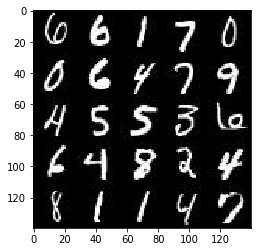

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

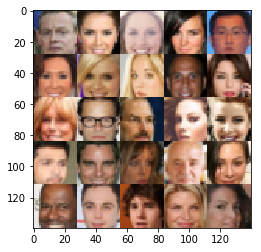

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2,rate=0.2,training=True)

        # 7*7*128
        
        x3 = tf.layers.conv2d(relu2,256,6, strides=1, padding= 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3,rate=0.25,training=True)

        # 7*7*256
        #print((relu2))
        
        flat = tf.reshape(relu3,(-1,7*7*256))
        logits = tf.layers.dense(flat,1,kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
#     print(reuse)
#     print('is')
#     print(is_train)
    with tf.variable_scope('generator', reuse=not is_train):        
        x1=tf.layers.dense(z,7*7*1024,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.reshape(x1,(-1,7,7,1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         x1 = tf.layers.dropout(x1,rate=0.2,training=True)

        # 7*7*1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 7, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2,rate=0.2,training=is_train)

        # 7*7*512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14x256
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4,rate=0.2,training=is_train)

        # 14*14x128

        # Output layer
        logits = tf.layers.conv2d_transpose(x4,out_channel_dim, 3, strides=2, padding='same')
#         print(logits)
        out = tf.tanh(logits)

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function

    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    losses =[]
    steps = 0
    print_every=10
    show_every=100

    # TODO: Build Model
    _,w,h,d = data_shape
    input_real, input_z, lr = model_inputs(w, h, d, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, d, alpha=alpha)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
#                 print('Min: ', batch_images.min())
#                 print('Max: ', batch_images.max())
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: 0.5*learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
#                 _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, d, data_image_mode)

    
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [22]:
batch_size = 32
z_dim = 150
learning_rate = 0.0001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    mlosses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

KeyboardInterrupt: 

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

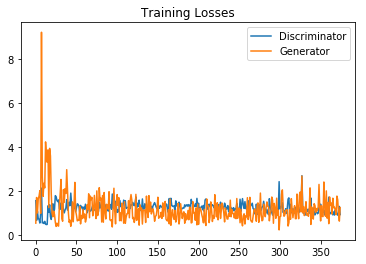

In [16]:
fig, ax = plt.subplots()
mlosses = np.array(mlosses)
plt.plot(mlosses.T[0], label='Discriminator')
plt.plot(mlosses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 2.5373... Generator Loss: 0.3869
Epoch 1/2... Discriminator Loss: 2.3135... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.6953... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.7987... Generator Loss: 1.3459
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 1.4823
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.6307
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.1412
Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 1.3392
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.5869
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 2.2967


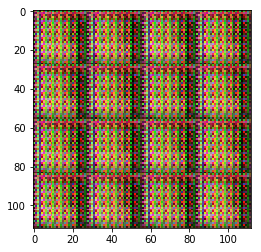

Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.8881
Epoch 1/2... Discriminator Loss: 1.6418... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.6731... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 1.5032... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.0299
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 1.1108


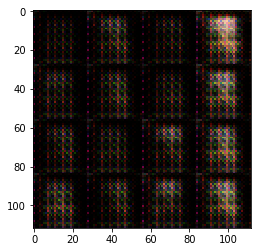

Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 1.3255
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 1.1014


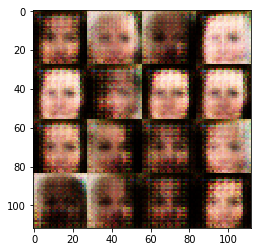

Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 1.8520
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 1.5863
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 1.1131
Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.9625... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 1.0182


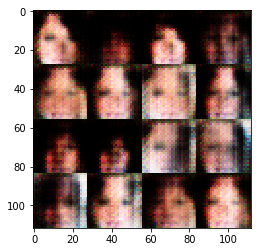

Epoch 1/2... Discriminator Loss: 1.6173... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 1.0744
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 1.0814
Epoch 1/2... Discriminator Loss: 1.6129... Generator Loss: 1.8719
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.8087


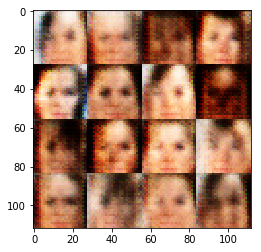

Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 2.0010
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 1.1246
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.5482
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 1.6328... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.5698


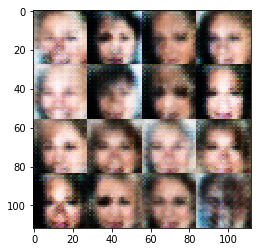

Epoch 1/2... Discriminator Loss: 1.6802... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 1.4905... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.6206... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 1.4108
Epoch 1/2... Discriminator Loss: 1.5138... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.7314


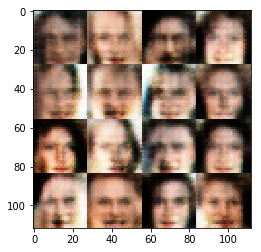

Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.6827... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.5711... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 1.5800... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 1.5731... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.6063... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.9225
Epoch 1/2... Discriminator Loss: 1.6401... Generator Loss: 0.8779


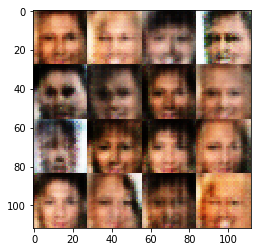

Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 1.6855... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.8918
Epoch 1/2... Discriminator Loss: 1.7820... Generator Loss: 0.5403


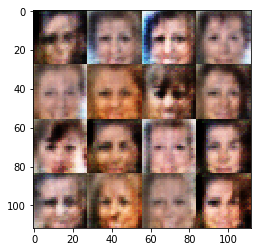

Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 1.5250... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.5534... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.6076... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.5477... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.7337... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 1.0396


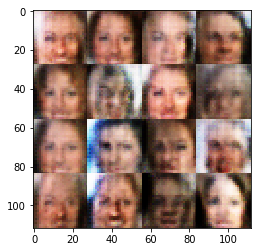

Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.8379
Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.6218... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.6152... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.8027


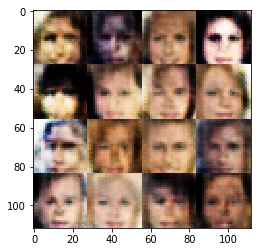

Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.9458
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.8712
Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 0.8591


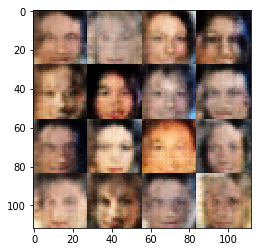

Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.5370... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.8269
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.5181... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.6466... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.9095


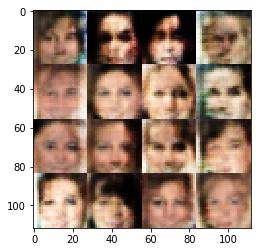

Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.9445
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 1.5212... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.5926... Generator Loss: 0.7184


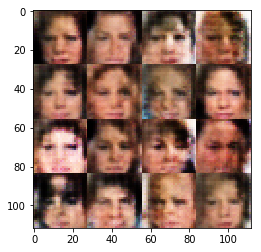

Epoch 1/2... Discriminator Loss: 1.4465... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.5643... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.4471... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.6554... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.7480


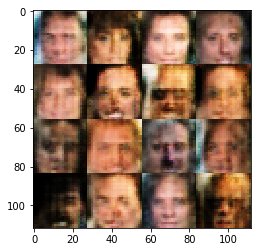

Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.5464... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.7908


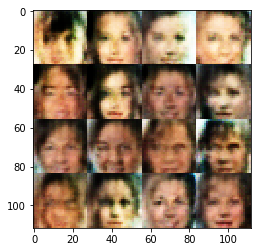

Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.8634
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.5064... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.7722
Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 0.7228


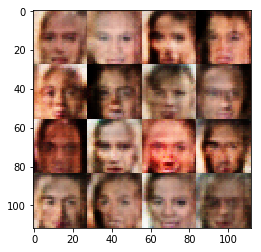

Epoch 1/2... Discriminator Loss: 1.5190... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 0.7526


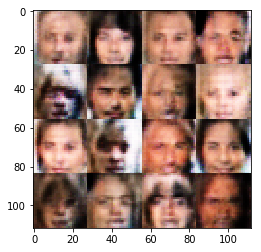

Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.5086... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.7414


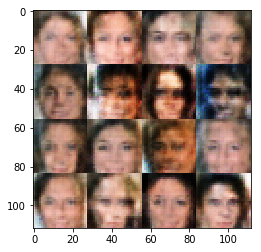

Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.9412
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.8451


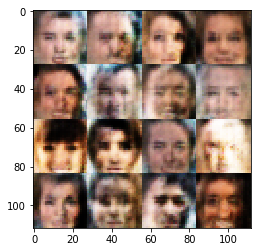

Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.8424


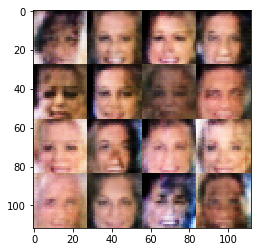

Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.5372... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.7610


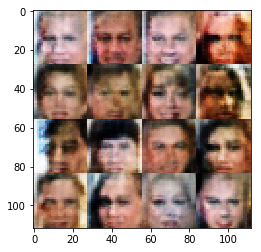

Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.8422
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.7774


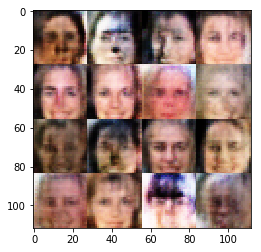

Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.5994... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.9038
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.5100... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.6904


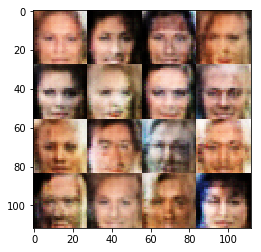

Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.9736
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.8017


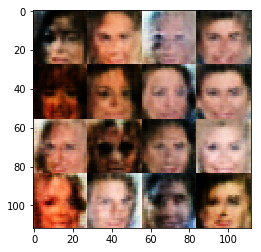

Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.8225
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.8203


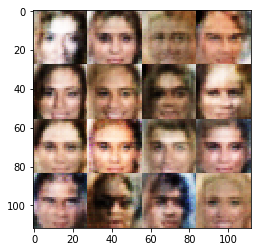

Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.5352... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 0.7711


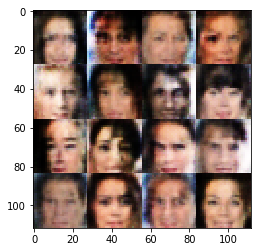

Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.8740


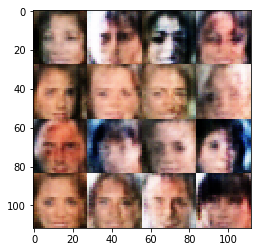

Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.8294


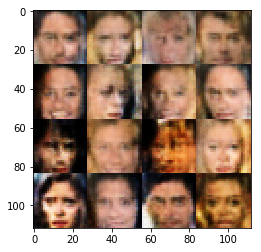

Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.8490


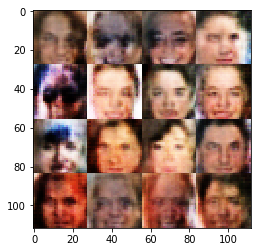

Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.7861


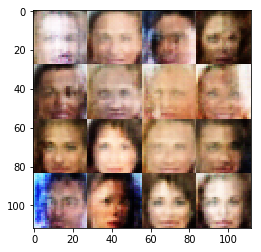

Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.7323
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.7986


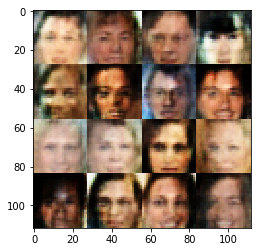

Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.8128
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.4365... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.9198


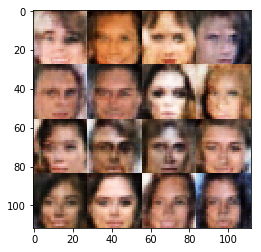

Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.7553
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.4740... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7666


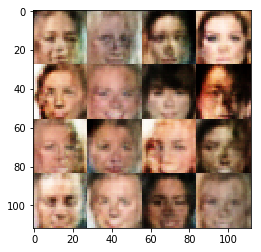

Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.5027... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 1.4483... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.7775


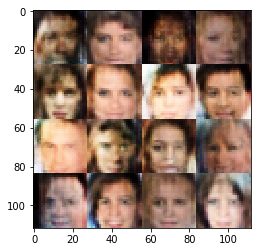

Epoch 2/2... Discriminator Loss: 1.4958... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 1.4468... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.4444... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.7304


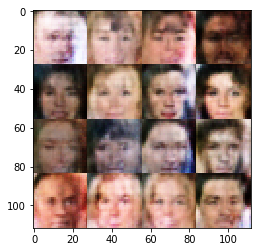

Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.7998
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.8530


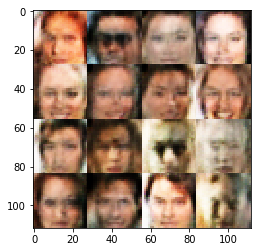

Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.4500... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.4562... Generator Loss: 0.8026


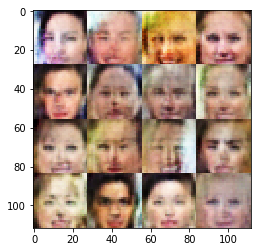

Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.4143... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.8284


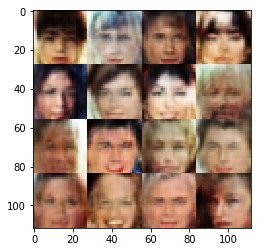

Epoch 2/2... Discriminator Loss: 1.4120... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.8262


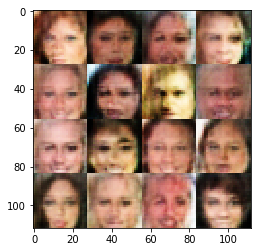

Epoch 2/2... Discriminator Loss: 1.4373... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.7483
Epoch 2/2... Discriminator Loss: 1.4856... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.8249


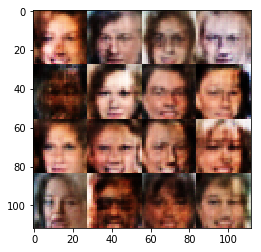

Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.7470
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8181
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 0.8415


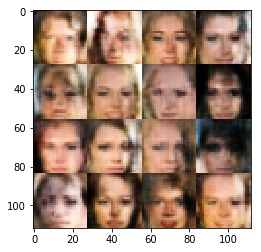

Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.7665
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8345


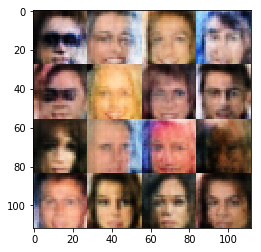

Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.8529


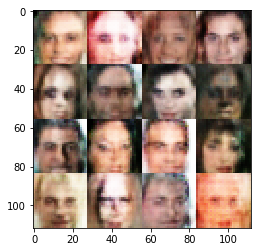

Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.7772


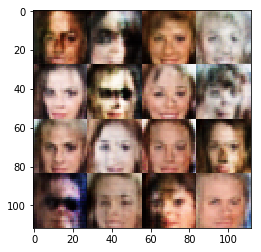

Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.7536


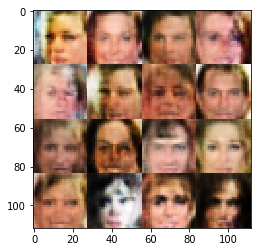

Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.7705


In [ ]:
batch_size = 64
z_dim = 150
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    flosses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
fig, ax = plt.subplots()
flosses = np.array(flosses)
plt.plot(flosses.T[0], label='Discriminator')
plt.plot(flosses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:

# # Hyperparameters
# IMAGE_SIZE = 128
# NOISE_SIZE = 100
# LR_D = 0.00004
# LR_G = 0.0002
# BATCH_SIZE = 64
# EPOCH = 0 # Non-zero only if we are resuming training with model checkpoint
# EPOCHS = 5 #EPOCH + number of epochs to perform
# BETA1 = 0.5
# WEIGHT_INIT_STDDEV = 0.02
# EPSILON = 0.00005
# SAMPLES_TO_SHOW = 5